In [1]:
%matplotlib inline 
from __future__ import print_function, division 
from IPython.display import display
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from descartes import PolygonPatch
import fiona
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection
from shapely.geometry import MultiPolygon, Polygon, shape
import gmaps
import pyproj
import googlemaps
import re
import numpy as np
import pandas as pd
import psycopg2
import cPickle as Pickle
import time
from datetime import datetime
import scipy
from sklearn.cluster import DBSCAN
from collections import Counter, defaultdict
from nltk.stem import porter
from sklearn.decomposition import NMF

# plt.style.available
plt.style.use('seaborn-white')

#### Get data to dataframe
- Data stored in postgresql database includes venues (all restaurants and governmental services were filtred out to reduce categories complexity)

In [2]:
pg_conn = psycopg2.connect(database='citi', host='localhost', port='5432')
pg_cur = pg_conn.cursor()

# Query venue table; skip venues with no likes, lists, tips, and checkins
colns = ['vid','name', 'Lat','Lng', 'photos', 'lists', 'checkins', 'tips', 'visits', 'users',
         'likes', 'isTran', 'njProp', 'url', 'langprop']
pg_cur.execute( """SELECT * FROM venues  
                       WHERE lists !=0 AND likes != 0 AND checkins !=0 AND tips != 0 AND \
                                vid NOT IN ('4be4f932d4f7c9b61df92420', '4b0587a6f964a5203e9e22e3')"""  )
df_venue = pd.DataFrame(pg_cur.fetchall(), columns=colns)

# Query photos table 
colns = ['vid','sid','pid','time','checkin','checkinTime','timeOffset']
pg_cur.execute( """SELECT * FROM photos WHERE vid IN ( \
                           SELECT DISTINCT vid FROM venues WHERE \
                           lists !=0 AND likes != 0 AND checkins !=0 AND tips != 0 AND\
                           vid NOT IN ('4be4f932d4f7c9b61df92420', '4b0587a6f964a5203e9e22e3'))""" )
df_photo = pd.DataFrame(pg_cur.fetchall(), columns=colns)
df_photo = df_photo.loc[df_photo['vid'].isin(df_venue['vid'])]

# Query tips table 
colns = ['vid', 'sid', 'time', 'lang', 'justification', 'authorInteractionType', 'tid', 't_type', 'logView','likes', 
        'save', 'url', 'agreeCount','disagreeCount','content','hasphoto','entities', 'langprop']
pg_cur.execute( """SELECT * FROM tips WHERE vid IN (\
                           SELECT DISTINCT vid FROM venues WHERE \
                           lists !=0 AND likes != 0 AND checkins !=0 AND tips != 0);""" )
df_tip = pd.DataFrame(pg_cur.fetchall(), columns=colns)
df_tip = df_tip.loc[df_tip['vid'].isin(df_venue['vid'])]

# Query user table 
colns = ['sid','homecity','followers','following','cities','citiesCount','listCount']
pg_cur.execute( """SELECT * FROM users WHERE homecity IS NOT NULL;""")
df_user = pd.DataFrame(pg_cur.fetchall(), columns=colns)
# Convert homecity column to string type and strip space
df_user['homecity'] = df_user['homecity'].str.strip()

# Query venue categories table 
colns = ['vid','cid', 'cname']
pg_cur.execute("""SELECT * FROM categories_vid;""")
df_category = pd.DataFrame(pg_cur.fetchall(), columns=colns);
pg_conn.commit()
pg_conn.close()

print ('venues:')
print (display(df_venue.shape));
print (display(df_venue.head(3)));
print ('users:', df_user.shape)
print (display(df_user.head(3)))
print ('photos:', df_photo.shape)
print (display(df_photo.head(3)))
print ('tips:', df_tip.shape)
print (display(df_tip.head(3)))
print ('categories:', df_category.shape)
print (display(df_category.head(3)))

venues:


(2872, 15)

None


,vid,name,Lat,Lng,photos,lists,checkins,tips,visits,users,likes,isTran,njProp,url,langprop
0,4b5a85f8f964a5209ec928e3,龍光院,35.680006,139.803520,51,9,197,1,234,190,1,0,0.025352,https://foursquare.com/v/%E9%BE%8D%E5%85%89%E9...,1.000000
1,4b5b9c24f964a520c70a29e3,三宝寺,35.736215,139.597591,32,4,106,2,112,79,1,0,0.024722,https://foursquare.com/v/%E4%B8%89%E5%AE%9D%E5...,1.000000
2,4b652d6df964a520b2e72ae3,LaQua,35.707098,139.752936,1116,52,21431,37,27051,14042,265,0,0.023579,https://foursquare.com/v/%E3%83%A9%E3%82%AF%E3...,0.810811


None
users: (36268, 7)


,sid,homecity,followers,following,cities,citiesCount,listCount
0,10005188,"渋谷区, 日本",31,33,None,None,2
1,100055241,日本国 (not山),20,25,None,None,2
2,10006214,日本,18,22,None,None,2


None
photos: (131769, 7)


,vid,sid,pid,time,checkin,checkinTime,timeOffset
0,4b05879ff964a520259d22e3,1115846.0,4f6711cde4b08383b3eb7d94,2012-03-19 11:00:29,1.0,2012-03-19 11:00:29,540.0
1,4b05879ff964a520259d22e3,6975815.0,4f478bd1e4b0f85d06fe2b05,2012-02-24 13:08:33,1.0,2012-02-24 13:08:30,540.0
2,4b05879ff964a520259d22e3,1115846.0,4f6725cce4b0c7552f330492,2012-03-19 12:25:48,1.0,2012-03-19 11:00:29,540.0


None
tips: (21484, 18)


,vid,sid,time,lang,justification,authorInteractionType,tid,t_type,logView,likes,save,url,agreeCount,disagreeCount,content,hasphoto,entities,langprop
0,5091f2f1e4b078f92c0fbcf9,NaN,None,None,None,None,None,None,None,NaN,NaN,None,NaN,NaN,None,None,None,None
1,51382ecbe4b0245fdf072c62,NaN,None,None,None,None,None,None,None,NaN,NaN,None,NaN,NaN,None,None,None,None
2,521c352a11d2ff3e0ef50b3d,NaN,None,None,None,None,None,None,None,NaN,NaN,None,NaN,NaN,None,None,None,None


None
categories: (46272, 3)


,vid,cid,cname
0,56ff8f73498e9592d320f632,56aa371be4b08b9a8d5734db,Amphitheater
1,4fb4e9c3e4b06fa0ebde83c7,56aa371be4b08b9a8d5734db,Amphitheater
2,5757b57b498e33d52c4a2313,56aa371be4b08b9a8d5734db,Amphitheater


None


In [3]:
# Remove train stations, except for Tokyo and shibuya Stations which are both
# popular travel attractions according to tripadvisor
df = pd.concat([df_venue[ (~ df_venue.name.str.contains('Station|駅')) ],
           df_venue[df_venue.name.str.contains('Tokyo Station|渋谷駅')] ]).merge(df_category, on='vid', how='inner')
df_tip = df_tip[df_tip.vid.isin(df.vid)]
df_photo = df_photo[df_photo.vid.isin(df.vid)]

#### Use DBScan algorithm to explor the spatial pattern of popular venues 
- Apply DBScan to explore the distribution/density of city attractions in Tokyo
- Tokyo bity boundary shapefile were donwload from ESRI website (http://www.esrij.com/products/japan-shp/)
- Longitude and Latitude were projected to UTM coordinate system 
- DBScan algorithm has two parameters: epsilon was set to 1200 meters to explore attractions within walking/ public transportation accessibility distances; minimum sample size was determined by gradient search and visualizing the results 

In [4]:
def loadShp(shp_path = '../data/tokyo.shp'):
    """
    INPUT: path_str
    OUPUT: polygon instance
    """
    geom_list = []
    with fiona.open(shp_path, 'r') as cell_f:
        for feature in cell_f:
            ftr_geom = shape(feature['geometry'])

            if ftr_geom.is_empty:
                continue
            elif ftr_geom.geom_type == 'MultiPolygon':
                # Unpack multi-polygons to lists of polygons
                geom_list.extend([g for g in ftr_geom if not g.is_empty])
            elif ftr_geom.geom_type == 'Polygon':
                geom_list.append(ftr_geom)
            else:
                print('Invalid geometry type')
                continue
    mp = MultiPolygon(geom_list)
    return mp

def plotCluster(df, label_column, map_patch, cmap_selected='Paired', outlier=True):
    """
    INPUT: dataframe, str, polygon instance, str, boolean 
    OUTPUT: fig, ax
    """
    fig, ax = plt.subplots(1,1, figsize=(16,10))
    # Get user picked colormap
    cmap = plt.get_cmap(cmap_selected)
    # extract all colors from the colormap
    cmaplist = [cmap(i) for i in range(cmap.N)]
    
    if outlier:
        # Change thefirst color entry to be grey
        cmaplist[0] = (.8,.8,.8,1.0)
    else:
        pass
    # Create new colormap
    customized_cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

    # define the bins and normalize
    num_labels = df[label_column].unique().size
    if num_labels > 1:
        bounds = np.linspace(-1, num_labels-1, num_labels+1)
    else:
        bounds = [0]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    ax.set_xlim(138.9, 140)
    ax.set_ylim(35.49, 35.9)                      #plt.cm.Set3
    ax.scatter(df.Lng, df.Lat, c=df[label_column],
               cmap=customized_cmap, marker='o', edgecolors='none', label=df[label_column])
    patches = [PolygonPatch(p, fc='none', ec='0.1', zorder=1) for p in map_patch]
    ax.add_collection(PatchCollection(patches, match_original=True))

    ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])

    cb = mpl.colorbar.ColorbarBase(ax2, cmap=customized_cmap, 
                                   norm=norm, spacing='proportional', 
                                   ticks=bounds.astype(int)[:-1],
                                    boundaries=bounds, format='%1i')
    cb.set_ticklabels(['outlier','G0','G1','G2','G3','G4'])
    ax2.set_ylabel('Cluster Label', size=12)
    return fig, ax

L1
-1    1455
 0     493
 1     140
 2      81
 3      52
 4      52
Name: vid, dtype: int64


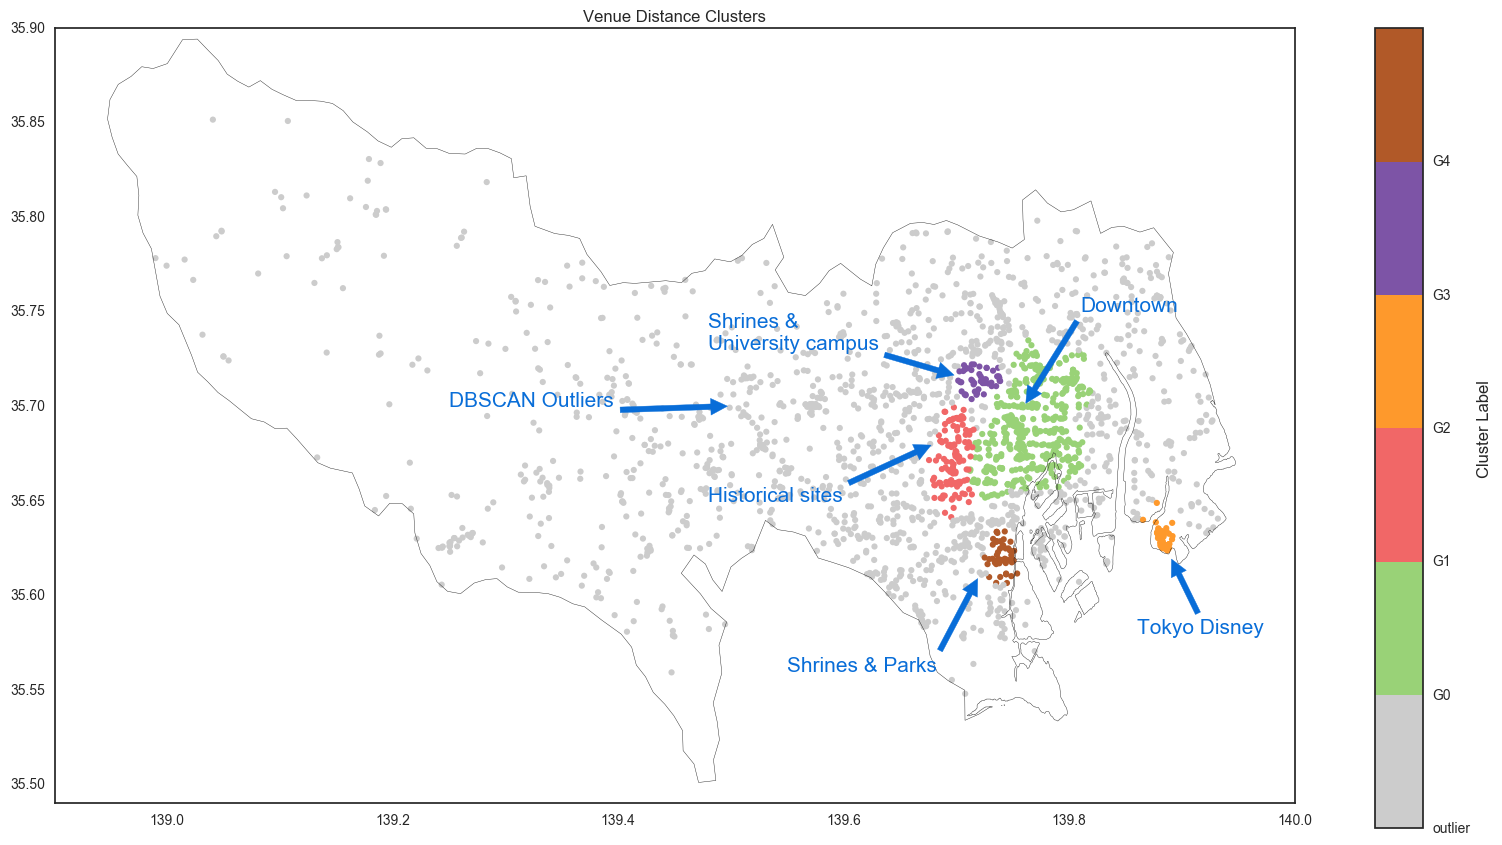

In [5]:
UTM54N = pyproj.Proj("+init=EPSG:32654")
df['utmLng'], df['utmLat'] = UTM54N(df['Lng'].values, df['Lat'].values)
X = df[['utmLat','utmLng']].values   # 'percent_like', 'users','isTran' ,'langprop'

# Run DBSCAN
db = DBSCAN(eps=1200, min_samples=35).fit(X)
df.loc[:, 'L1'] = (db.labels_).astype(int)
print (df.groupby('L1')['vid'].count())

mp = loadShp()
fig, ax=plotCluster(df, 'L1', mp)
ax.set_title('Venue Distance Clusters')
ax.annotate('Tokyo Disney', xy=(139.89, 35.62), xytext=(139.86, 35.58),
            arrowprops=dict(facecolor='#086dd8', shrink=0.03, edgecolor='#086dd8'), size=15, color='#086dd8')
ax.annotate('Downtown', xy=(139.76, 35.7), xytext=(139.81, 35.75),
            arrowprops=dict(facecolor='#086dd8', shrink=0.03, edgecolor='#086dd8'), size=15, color='#086dd8')
ax.annotate('Shrines & Parks', xy=(139.72, 35.61), xytext=(139.55, 35.56),
            arrowprops=dict(facecolor='#086dd8', shrink=0.03, edgecolor='#086dd8'), size=15, color='#086dd8')
ax.annotate('Shrines & \nUniversity campus', xy=(139.70, 35.716), xytext=(139.48, 35.73),
            arrowprops=dict(facecolor='#086dd8', shrink=0.03, edgecolor='#086dd8'), size=15, color='#086dd8')
ax.annotate('Historical sites', xy=(139.68, 35.68), xytext=(139.48, 35.65),
            arrowprops=dict(facecolor='#086dd8', shrink=0.03, edgecolor='#086dd8'), size=15, color='#086dd8')
ax.annotate('DBSCAN Outliers', xy=(139.5, 35.7), xytext=(139.25, 35.7),
            arrowprops=dict(facecolor='#086dd8', shrink=0.03, edgecolor='#086dd8'), size=15, color='#086dd8')

plt.show()

In [6]:
import gmaps

gmaps.configure(api_key) 
m = gmaps.Map()

for (lbl, col) in zip([-1,0,1,2,3,4], ['gray','#4286f4','#42f4ce','#d1f442','#f49b42','#ad3a3a']): #np.unique(df['label']):
    dfSub = df[df['L1']==lbl]
    venue_locations = [(x,y) for (x,y) in zip(dfSub['Lat'], dfSub['Lng'])]
    venue_layer = gmaps.symbol_layer(venue_locations, fill_color=col, stroke_color=col, scale=2)
    m.add_layer( venue_layer )
m

- Applied geocodin and language detection to get part of the solution, and manually finialize the check list to a dictionary in this format: {'venue name': group it belongs to} 
- Assign user group (Tokyo, other area in Japan, and foreign) by geolocation. Google geocoding API works for part of the data but threw exceptions painful slow. 

#### Process tip entities
- Tip table has a 'entities' column contains high frequencies words appears in the same entry 
- The purpose of this analysis is to clsuter the tips (and thus the associated venues ) based on the relative frequencies of tip words

In [7]:
def get_unique(lst):
    """
    INPUT: list
    OUTPUT: list
    """
    filtered = list()
    for x in lst:
        if x not in filtered and x!= 'None':
            filtered.append(x)
    return filtered


def word_stem(words):
    """
    INPUT: list 
    OUTPUT: list
    """
    stemmer = porter.PorterStemmer()
    return [stemmer.stem(word.decode('utf-8')) for word in words]


def dic_mapping(x, dic2map):
    """
    INPUT: list, dictionary
    OUTPUT: list
    """
    mapped_output = list()
    if type(x) == str:
        temp = x.split(',')
    elif type(x) == int:
        temp = [x]
    for elem in temp:
        try:
            mapped_output.append(dic2map[elem])
        except:
            mapped_output.append(elem)
    return get_unique(mapped_output)


def updateWordVector(data, allwords, word_exist_vector):
    """
    INPUT: list (string), list (string), list (int)
    OUPUT: list (int)
    
    Take a list of words as corpus, if a word exists in a document, 
    place 1 in the word_exist_vector, otherwise 0
    data: List of word document, 
    allwords: Corpus, 
    word_exist_vector: List has same length with 'allwords' list
    """
    for i in xrange(len(allwords)):
        for word in data:
            if allwords[i]==word:
                word_exist_vector[:,i]=1
    return word_exist_vector


# Functions to summarize NMF result 
def reconst_mse(target, left, right):
    return (np.array(target - left.dot(right))**2).mean()


def describe_nmf_results(document_term_mat, W, H, feature_words, n_top_words = 25):
    print("Reconstruction error: {}".format(reconst_mse(document_term_mat, W, H)))
    for topic_num, topic in enumerate(H):
        print("Topic %d:" % topic_num)
        print(" ".join([feature_words[i] \
                for i in topic.argsort()[:-n_top_words - 1:-1]]))
    return 

# Vectorize the function to apply on numpy array
def f_strip(x): return x.strip()
f_strip = np.vectorize(f_strip)  # or use a different name if you want to keep the original f


def create_word_vector(df, idColumn = 'vid', documentsColumn = 'entities'):
    """
    INPUT: pandas dataframe, string, string
    OUPUT: ndarray
    
    Take a dataframe (contains the entire corpus) and id column name, 
    word document column name, convert the corpus to a 2D ndarray
    with value 0 and 1
    """
    # Create a pandas aggregating funciton to apply on entities column 
    f_agg = { documentsColumn:sum }
    df_entry_vid = df[[idColumn,  documentsColumn]].groupby(idColumn, as_index=False).agg(f_agg)

    # Create corpus
    corpus = np.unique(np.concatenate(df_entry_vid.entities))
    corpus = corpus[corpus!='nan']
    
    # Strip each word
    corpus = f_strip(corpus)
    
    # Create a temp vector to store the value of each iteration 
    temp_vector = np.zeros((1,len(corpus)))
    
    # Initiate the the first documnet 
    document = df_entry_vid.entities[0]
    word_vector = updateWordVector(document, corpus, temp_vector )
    
    # Iterate through each entry in the file to fill the word vector with the updateWordVector function 
    for idx, venue in enumerate(np.unique(df_entry_vid.vid[1:])):
        document = df_entry_vid[df_entry_vid.vid==venue].entities.values[0]
        temp_vector = updateWordVector(document, corpus, temp_vector )
        word_vector = np.vstack((word_vector, temp_vector))
    return word_vector, corpus, df_entry_vid


def runNMF(word_vector, corpus, n_topics):
    """
    INPUT: ndarray (2D), ndarray (1D), int
    OUTPUT: ndarray(2D), ndarray(2D)
    
    Run NMF analysis on word vectors; Manually test to determine suitable number of topics
    """
    nmf = NMF(n_components=n_topics, random_state=1,
              alpha=.1, l1_ratio=.5)
    nmf.fit(word_vector)

    W = nmf.fit_transform(word_vector)
    H  = nmf.components_
#     describe_nmf_results(word_vector, W, H, feature_words=corpus)
    return W, H

def assign_topic(x):
    """
    INPUT: list
    OUTPUT: list
    
    Sort the group vector and get the top 2 
    """  
    idxs = np.argsort(x)[::-1]
    if x.sum() == 0.:
        ouput = np.empty(2) * -1
    else:
        output = idxs[0:2]       
    return output

#### Group user by homecity with predefined homecity-area dictionary

In [8]:
def update_dic_homecity(d, citynamelist='../data/locNameDic.p'):
    """
    INPUT: dictionary, path
    OUTPUT: dictionary
    
    Load the predifined venue: group dictionary 
    """
    with open(citynamelist, 'r') as f:
        locNameList = Pickle.load(f)
        forignlst = locNameList['forignlst']
        japanlst = locNameList['japanlst']
        tokyolst = locNameList['tokyolst']

    for i, c in enumerate(cities):
            for char1 in forignlst:
                if char1 in c:
                    d[c] = 'foreign'

            for char2 in japanlst:
                if char2 in c:
                    d[c] = 'japan'

            for char3 in tokyolst:
                if char3 in c:
                    d[c] = 'tokyo'
    return d


def assignLoc(city):
    """
    INPUT: string
    OUPUT: string
    """
    try:
        return d[city]
    except:
        return 'none'

cities = df_user.homecity.unique()
d = {} 
d = update_dic_homecity(d)
df_user.homecity = df_user.loc[:,'homecity'].apply(assignLoc)
df_user.head()

,sid,homecity,followers,following,cities,citiesCount,listCount
0,10005188,tokyo,31,33,None,None,2
1,100055241,japan,20,25,None,None,2
2,10006214,japan,18,22,None,None,2
3,100062903,japan,17,27,None,None,2
4,10006511,tokyo,27,28,None,None,2


In [9]:
print (df_user.groupby('homecity', as_index=False).count()[['homecity','sid']])

  homecity    sid
0  foreign   3989
1    japan   8908
2     none    343
3    tokyo  23028


#### Convert tip entities to vector
- The output is an numpy ndarray of length of the corpus
- For each documnet of words (words appear in tips of each vid), if a word appear in the corpus, fill the poistion with 1, otherwise 0

In [10]:
# Join user dataframe with other tables
df_alluser = df_user.merge(df_tip, on=['sid'], how='inner').\
                merge(df_photo, on=['vid','sid'], how='outer').\
                merge(df_category[['vid','cname']], on= 'vid', how='left')

# Group user by homecity
foreigner = df_alluser[df_alluser.homecity=='foreign']
japanese = df_alluser[df_alluser.homecity=='japan']
tokyoer = df_alluser[df_alluser.homecity=='tokyo']

# Find top reviewed veneus
foreigner_top_vid = (foreigner.groupby('vid', as_index=False).count().\
                    sort_values(by='sid', ascending=False).iloc[0:200,]).vid
japanese_top_vid = (japanese.groupby('vid', as_index=False).count().\
                    sort_values(by='sid', ascending=False).iloc[0:200,]).vid
tokyoer_top_vid = (tokyoer.groupby('vid', as_index=False).count().\
                    sort_values(by='sid', ascending=False).iloc[0:200,]).vid

# Subset user review dataframe : keep top 150 popular veneus 
top_venues = foreigner_top_vid.append(japanese_top_vid).append(tokyoer_top_vid).unique()
df_alluser = df_alluser[df_alluser.vid.isin(top_venues)]
foreigner = foreigner[foreigner.vid.isin(foreigner_top_vid )]


In [11]:
with open('../data/word_dic.p', 'r') as f:
    dicTranslate = Pickle.load(f)

df_alluser.entities = df_alluser.loc[:,'entities'].apply(lambda x: re.sub('\{\"|\"\}|"|{|}| ', '', str(x)))
df_alluser.entities = df_alluser.loc[:,'entities'].apply(dic_mapping, args=(dicTranslate,))
df_alluser.entities = df_alluser.loc[:,'entities'].apply(word_stem)

- outdoor/hiking attraction type were captured with this anlaysis, the tips dataset lacks this sort of information; e.g. attractions near Mt.Takao area mostly outdoor trails 
- The NMF result indicates this method is not very relevant here, but still provides some useful insignts. Since the total number of venues is just a few hunderd, I decided to manually adjust the category

In [12]:
word_vector, corpus, df_entry_vid = create_word_vector(df_alluser)
W, H = runNMF(word_vector, corpus, 5)  

- Assign new category names to each venue with the NMF extracted topic and manually combine the new category and the category assigned by user or foursqure system

In [13]:
dic2map = {0:'theme tour', 1:'game or outdoor', 2:'culture and history', 3:'local lifestyle',4:'service and shopping'}
venue_group = np.array([list(assign_topic(W[i])) for i in range(len(W))])

In [14]:
df_entry_vid['g1'] = venue_group[:, 0]
df_entry_vid['g2'] = venue_group[:, 1]
df_entry_vid.g1 = df_entry_vid.loc[:,'g1'].apply(dic_mapping, args=(dic2map,)).apply(lambda x: x[0])
df_entry_vid.g2 = df_entry_vid.loc[:,'g2'].apply(dic_mapping, args=(dic2map,)).apply(lambda x: x[0])

In [15]:
top_venues = df_entry_vid.merge(df[['vid','name','cname','L1','Lng','Lat']], on='vid',how='inner'). \
                drop_duplicates('vid')

top_venues.ix[ top_venues.cname.isin(['Rock Club','Hot Spring','Jazz Club']), 'g1'] = 'local lifestyle'
top_venues.ix[ top_venues.cname.isin(['Historic Site','Buddhist Temple','Temple','Shrine','Church','Palace']), \
              'g1'] = 'culture and history'
top_venues.ix[ top_venues.cname.isin(['Multiplex','Science Museum']), 'g1'] = 'theme tour'
top_venues.ix[ top_venues.cname.isin(['Arcade']), 'g1'] = 'game'
top_venues.ix[ top_venues.cname.isin(['Theme Park Ride','Zoo']), 'g1'] = 'theme tour'
top_venues.ix[ top_venues.cname.isin(['Mountain','Trail','Park']), 'g1'] = 'outdoor'
top_venues.ix[ top_venues.cname.isin(['Art Gallery','Public Art','Art Museum']), 'g1'] = 'art'
top_venues.ix[ top_venues.name.isin(['Tokyo DisneySea', 'Tokyo DisneyLand','Disneyland','Disneysea' 
                                      'DisneyLand', 'DisneySea','Zoo']), 'g1'] = 'theme tour'

In [16]:
top_venues['f']=0
top_venues['j']=0
top_venues['t']=0
top_venues.loc[top_venues.vid.isin(foreigner_top_vid),'f'] = 1
top_venues.loc[top_venues.vid.isin(japanese_top_vid),'j'] = 1
top_venues.loc[top_venues.vid.isin(tokyoer_top_vid),'t'] = 1

In [17]:
top_venues_cross = top_venues[(top_venues.f==1) & (top_venues.j==1) & (top_venues.t==1)]
top_venues_foreigner = top_venues[(top_venues.f==1)]# & (top_venues.j==0) & (top_venues.t==0)]
top_venues_japanese = top_venues[(top_venues.j==1)]#  & (top_venues.f==0) & (top_venues.t==0)]
top_venues_tokyoer = top_venues[(top_venues.t==1)]#  & (top_venues.j==0) & (top_venues.f==0)]

In [18]:
print ('Overlap:')
print (display(top_venues_cross.iloc[np.random.randint(1, len(top_venues_cross), 5),]));
print ('Foregin Visitors:')
print (display(top_venues_foreigner.iloc[np.random.randint(1, len(top_venues_foreigner), 5),]))
print ('Japanese Visitors:')
print (display(top_venues_japanese .iloc[np.random.randint(1, len(top_venues_japanese), 5),]))
print ('Tokyo Local Visitors:')
print (display(top_venues_tokyoer.iloc[np.random.randint(1, len(top_venues_tokyoer), 5),]))

Overlap:


,vid,entities,g1,g2,name,cname,L1,Lng,Lat,f,j,t
52,4b58295af964a520924c28e3,"[perform, theater, architectur, binocular, fac...",culture and history,theme tour,Kabuki-za Theater,Theater,0,139.767562,35.669183,1,1,1
68,4b59ebdaf964a52002a128e3,"[park, disneysea, fanci, hormone roast, fastpa...",theme tour,culture and history,Tokyo Disneyland,Theme Park,2,139.879380,35.635106,1,1,1
29,4b55d735f964a52055f227e3,"[temporary ticket g, chicken meat, skate, hike...",theme tour,local lifestyle,Shinjuku Piccadilly,Multiplex,1,139.703640,35.692916,1,1,1
146,4b6573cff964a520fdf02ae3,"[photograph, flemarket, photograph, screen, ph...",theme tour,local lifestyle,Tower Of Terror,Theme Park Ride / Attraction,2,139.887883,35.624488,1,1,1
15,4b52966cf964a520328327e3,"[guard, electron, fanci, emerg, prohibit, fish...",culture and history,local lifestyle,Kanda Myojin Shrine,Shrine,0,139.767582,35.701430,1,1,1


None
Foregin Visitors:


,vid,entities,g1,g2,name,cname,L1,Lng,Lat,f,j,t
148,4b658d10f964a52020f42ae3,"[corner, quiet, garden, yuzu, instrument, car,...",theme tour,local lifestyle,Koishikawa Botanical Gardens,Botanical Garden,-1,139.746435,35.718306,1,0,0
188,4b77b888f964a52023a82ee3,"[craft beer, craft beer, comedi, kisho kurokaw...",theme tour,local lifestyle,Turtle Talk,Theme Park Ride / Attraction,2,139.887199,35.623605,1,0,0
153,4b6811b3f964a520ff652be3,"[voice guid, tire, voice guid, music, voice gu...",game,local lifestyle,タイトーステーション 新宿東口店,Arcade,1,139.701441,35.693489,1,0,0
189,4b77bae1f964a52082a82ee3,"[port, cliff, rose, all you can eat, coast, to...",local lifestyle,local lifestyle,Saya no Yudokoro,Hot Spring,-1,139.692386,35.770830,1,1,1
158,4b6bd362f964a520bd192ce3,"[toast, fireworks display, change room, change...",theme tour,local lifestyle,Western River Railroad,Theme Park Ride / Attraction,2,139.882393,35.633725,1,0,0


None
Japanese Visitors:


,vid,entities,g1,g2,name,cname,L1,Lng,Lat,f,j,t
341,4c78ff49f2b89c7432ef9fbc,"[yen, bath towel, bath towel, bath towel, bath...",theme tour,game or outdoor,神山公園,Field,-1,139.531418,35.775718,0,1,0
370,4d32df0d2e56236a52f020b4,"[attract, chicken meat, bicycle rent, nan, nan...",theme tour,service and shopping,Mickey's PhilharMagic,Theme Park Ride / Attraction,2,139.880684,35.631550,1,1,0
426,4fda7ecfe4b05b85932c4716,"[yen discount, cafeteria, chai, red win, desig...",theme tour,service and shopping,LEGOLAND Discovery Center Tokyo,Theme Park,-1,139.776238,35.629031,1,1,1
438,5322bcf6498e455c659eaf52,"[crowd, fanci, internet caf, shoe, skate, skat...",theme tour,service and shopping,TOHO Cinemas,Multiplex,0,139.774631,35.686685,0,1,1
372,4d3b87ba44f5a0937583c4bb,"[corner, corner, corner, nan, nan, nan, nan, nan]",theme tour,service and shopping,烏山中学校 温水プール,Pool,-1,139.600375,35.672165,0,1,0


None
Tokyo Local Visitors:


,vid,entities,g1,g2,name,cname,L1,Lng,Lat,f,j,t
230,4b89d50af964a520e34f32e3,"[cinema, ferris wheel, then, bacon, jiyugaoka,...",theme tour,game or outdoor,寅さん記念館,Museum,-1,139.880581,35.757337,0,0,1
213,4b7ffa0af964a520174830e3,"[pinbal, arch, set meal, ampiaselezion, heaven...",game,local lifestyle,高田馬場ゲーセン ミカド,Arcade,3,139.703385,35.712672,1,0,1
400,4e8565a993ad38641050cf39,"[with, with, with, with, with, with, with, wit...",theme tour,service and shopping,Soka Gakkai Headquater,Spiritual Center,0,139.719709,35.680912,0,0,1
238,4b909467f964a520da9033e3,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",outdoor,game or outdoor,多摩川中央公園,Park,-1,139.326233,35.730306,0,0,1
316,4bfb8f9fd2b720a1d621336a,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",theme tour,game or outdoor,茜屋橋,Bridge,-1,139.496649,35.714336,0,0,1


None


#### Content analysis also does not shown meanful results 

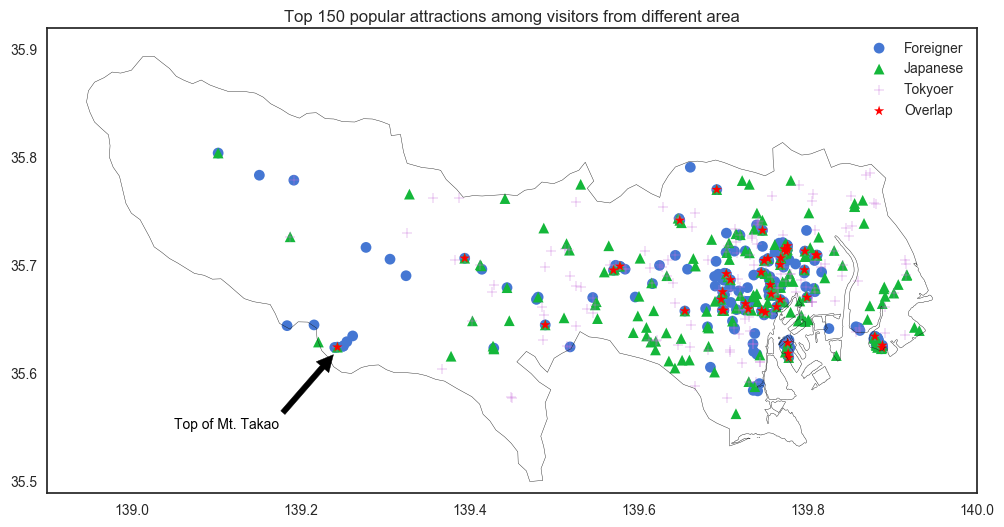

In [19]:
fig, ax = plt.subplots(1,1, figsize=(12,6))

ax.set_xlim(138.9, 140)
ax.set_ylim(35.49, 35.92)   

grps = [top_venues_foreigner, top_venues_japanese, top_venues_tokyoer, top_venues_cross]
colors = ['#4577d3','#14b73a','#c972db','red']
markers = ['o','^','+', '*']
labels = ['Foreigner','Japanese','Tokyoer','Overlap']

for _g, _c, _m, _l in zip( grps, colors, markers, labels ):
    ax.scatter( _g['Lng'], _g['Lat'], c=_c, marker=_m, s=60, edgecolors='none', label=_l)

ax.set_title('Venue Distance Clusters')
patches = [PolygonPatch(p, fc='none', ec='0.1', zorder=1) for p in mp]
ax.add_collection(PatchCollection(patches, match_original=True))
ax.legend(frameon=False)
ax.set_title('Top 150 popular attractions among visitors from different area')

ax.annotate('Top of Mt. Takao', xy=(139.241, 35.62), xytext=(139.05, 35.55),
            arrowprops=dict(facecolor='black', shrink=0.03, edgecolor='black'), size=10, color='black')

plt.show()

In [20]:
# Create dataframe for plotting 
df_bar = pd.DataFrame( {'L1': range(-1, 5), 
                     'foreign': [x[1] for x in sorted(Counter(top_venues_foreigner.L1).iteritems())],
                     'japan': [x[1] for x in sorted(Counter(top_venues_japanese.L1).iteritems())],
                     'tokyo': [x[1] for x in sorted(Counter(top_venues_tokyoer.L1).iteritems())]
                       })

In [21]:
pdlist = [pd.DataFrame({'g1':top_venues.g1.unique()}),
           top_venues_foreigner.groupby('g1', as_index=False).count()[['g1','vid']],
          top_venues_japanese.groupby('g1', as_index=False).count()[['g1','vid']],
          top_venues_tokyoer.groupby('g1', as_index=False).count()[['g1','vid']],
         top_venues_cross.groupby('g1', as_index=False).count()[['g1','vid']]]

df_bar_g1 = pdlist[0].merge(pdlist[1], on='g1', how='left').merge(pdlist[2], on='g1', how='left').\
            merge(pdlist[3], on='g1', how='left').merge(pdlist[4], on='g1', how='left').fillna(0)
df_bar_g1.columns= ['category','foreign','japan','tokyo','cross']
df_bar_g1.cross = df_bar_g1.cross.astype(int)
df_bar_g1

,category,foreign,japan,tokyo,cross
0,local lifestyle,12,15,16,3
1,culture and history,46,48,40,15
2,outdoor,27,30,58,7
3,art,15,14,9,4
4,theme tour,93,89,74,14
5,game,7,4,3,0


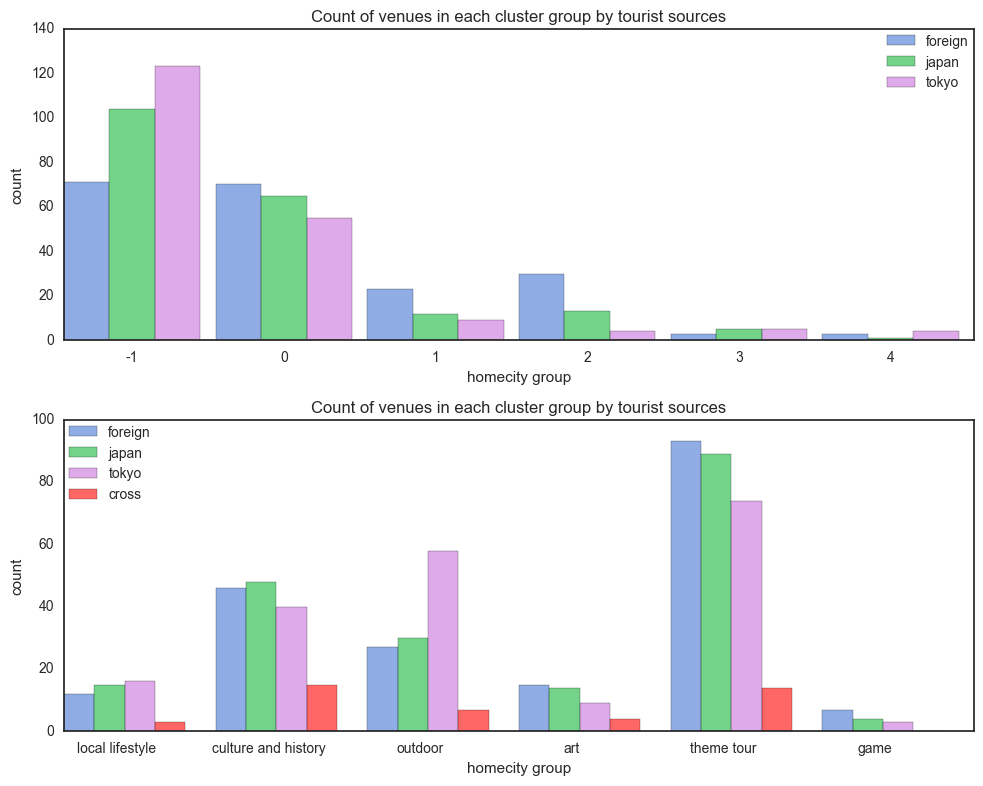

In [22]:
def bars(fig, ax_num, df, vx, wid, *args):
    cmap = plt.get_cmap('Paired')
    
    cols = sns.color_palette("Set2", len(args[0]))

    ax = fig.add_subplot(ax_num)
    xs = np.arange(len(df[vx]))
    
    plt_obj = list()
    for idx, coln in enumerate(zip(args[0], colors)):
        plt_obj.append(ax.bar(xs + wid*idx, df[coln[0]], wid, alpha=0.6, label=coln[0], color=coln[1]))

    x_labels = list(df[vx]) 
    ax.set_xticks(xs + wid*len(args)+0.15);
    ax.set_xticklabels(x_labels);
    return ax, plt_obj
    
# Create figure instance and grid   
fig = plt.figure(figsize = (10, 8));
gs = gridspec.GridSpec(2, 1)


# Bar plot 
wid = 0.3
ax,plt_obj = bars(fig, gs[0,:], df_bar, 'L1', wid, ['foreign','japan','tokyo'])
ax.set_xlabel("homecity group")
ax.set_ylabel("count")
ax.legend(handles=plt_obj, loc=1, borderaxespad=0.)
plt.title('Count of venues in each cluster group by tourist sources')

wid = 0.2
ax,plt_obj = bars(fig, gs[1,:], df_bar_g1, 'category', wid, ['foreign','japan','tokyo','cross'])
ax.set_xlabel("homecity group")
ax.set_ylabel("count")
ax.legend(handles=plt_obj, loc=2, borderaxespad=0.)
plt.title('Count of venues in each cluster group by tourist sources')


fig.tight_layout()
plt.show()

- Outdoor topic was not captured by this analysis, e.g.Mt. Takao and nearby attractions are mostly outdoors/trails, which were not shown in the NMF topwords 

In [23]:
top_venues_foreigner[ top_venues_foreigner.Lng < 139.3]

,vid,entities,g1,g2,name,cname,L1,Lng,Lat,f,j,t
81,4b5bb4baf964a520341129e3,"[stair, cute, stair, scenicview, for women onl...",culture and history,culture and history,高尾山 薬王院,Buddhist Temple,-1,139.250287,35.625894,1,0,0
143,4b650d11f964a5207ce12ae3,"[mountain, climb, chairlift, rout, pilgrim, iw...",outdoor,local lifestyle,Top of Mt. Takao,Mountain,-1,139.243658,35.625120,1,1,1
250,4b9a6bc7f964a520e1b335e3,"[water park, parking place fre, ramen shop, he...",theme tour,game or outdoor,Summerland Water Adventure,Water Park,-1,139.277501,35.717371,1,0,0
262,4ba6d2f9f964a520c37139e3,"[bacon, bacon, nan, nan, nan, nan, nan, nan, n...",theme tour,game or outdoor,金比羅台園地,Field,-1,139.261726,35.635492,1,0,0
263,4ba6f9fdf964a520e17a39e3,"[day by day, , ferris wheel, yen discount, all...",local lifestyle,game or outdoor,Moegi no Yu,Hot Spring,-1,139.102616,35.804636,1,1,0
281,4bc54ce86a3e9c74e3c7f548,"[lakesid, nan, nan, nan, nan, nan, nan, nan, n...",outdoor,game or outdoor,明王峠,Trail,-1,139.184126,35.645000,1,0,0
282,4bc55863ccbcef3b1879e6d2,"[river, castle tow, nan, nan, nan, nan, nan, n...",outdoor,game or outdoor,景信山,Mountain,-1,139.216022,35.645688,1,0,0
320,4c131d4d77cea5930367ce60,"[prohibit, prohibit, registered tangible cultu...",outdoor,game or outdoor,御岳山,Mountain,-1,139.151353,35.784126,1,0,0
334,4c453d64f97fbe9a9158bc30,"[miso, craft, craft, chicken meat, dayhik, tra...",outdoor,game or outdoor,Mt. Takao,Mountain,-1,139.250841,35.626223,1,0,0
362,4d0ef1e6ba378cfa66866e93,"[class gourmet, mushroom, bacon, mixed bath, g...",outdoor,service and shopping,高尾山 もみじ台,Trail,-1,139.240578,35.624887,1,0,0


#### Load category table to database

In [24]:
pg_conn = psycopg2.connect(database='citi', user='postgres', host='localhost', port='5432')
pg_cur = pg_conn.cursor()

In [25]:
top_venues = top_venues[['vid','g1','L1','f','j','t']]
top_venues.columns = ['vid','category','cluster','foreign','japan','tokyo']
rows = map(lambda x: tuple(x), top_venues.values)
com_CreateTb = """
                DROP TABLE IF EXISTS top200;
                CREATE TABLE top200(
                vid char(24) NOT NULL, 
                category text,
                cluster text,
                foreigner integer,
                japanese integer,
                tokyoer integer
                );
            """
pg_cur.execute( com_CreateTb ) 
args_str = ','.join(pg_cur.mogrify("(%s,%s,%s,%s,%s,%s)", x) for x in rows)
pg_cur.execute("INSERT INTO top200 VALUES " + args_str + ";") 
pg_conn.commit()

In [26]:
df_user = df_user[['sid','homecity']]
rows = map(lambda x: tuple(x), df_user.values)
com_CreateTb = """
                DROP TABLE IF EXISTS user_homecity;
                CREATE TABLE user_homecity(
                sid integer,
                homecity text
                );
            """
pg_cur.execute( com_CreateTb ) 
args_str = ','.join(pg_cur.mogrify("(%s,%s)", x) for x in rows)
pg_cur.execute("INSERT INTO user_homecity VALUES " + args_str + ";") 

pg_conn.commit()
pg_conn.close()

#### Summary:

- This EDA work was followed by another NMF on image-content-tags of a few photos dowloaded from the venues' pages, this approach was ceased due to time limit in training the auto-tagging model on Spark; This part of my work will be continuing as another project! 

- My recommender system product of this project will inlcude only the top 200 venues of each visitor source group (sum up to ~ 500 venues) as an toy exmaple that can be deployed on a small amazon instance. The framework can be extended when more data available, and he business features and A/B testing evaluation can be added. 

- The NMF analysis indicates visitors to all the venues tend to mention some food, which also indicates that food is an important element of city tourism! Restaurant recommender is not the topic of this project, but I am expecting to see interesting pattens among tourists from difference sources in Tokyo. 